# Portfolio Risk Analysis

The code performs a Risk Analysis on a stock's returns, using three different methods to calculate Value at Risk (VaR) and Expected Shortfall (CVaR). These are common risk metrics used in finance to assess the potential losses in a portfolio or individual asset over a specified time period with a given level of confidence. 

**The methods used are:**

- Parametric (Normal) VaR: Assumes returns follow a normal distribution.
- Historical VaR: A non-parametric approach that looks at past returns.
- T-distribution VaR: Uses a Student’s t-distribution, which is more robust when data contains outliers or heavy tails.

This project demonstrates the value of using multiple methods to assess risk, as each method offers unique insights into potential losses and tail risks. By incorporating both VaR and CVaR, we were able to obtain a more holistic view of Apple’s risk profile, providing investors and risk managers with valuable tools to make more informed decisions in managing portfolio risk.

## Load Data

In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, t
import matplotlib.pyplot as plt

## Inspecting Data

In [2]:
# Load data from ZIP
with zipfile.ZipFile('S&P 500 Stock Data.zip', 'r') as z:
    file_list = z.namelist()  # List all files (e.g., ['A.csv', 'AAL.csv', ...])
    
    # Load first 3 files as samples for inspection
    sample_data = {f: pd.read_csv(z.open(f)) for f in file_list[:3]}

# Inspect a sample file (e.g., A.csv)
print("Sample Data Structure:")
print(sample_data['A.csv'].head())
print("\nMetadata:")
print(sample_data['A.csv'].info())
print("\nMissing Values:")
print(sample_data['A.csv'].isnull().sum())
print("\nMissing Values:")
print(sample_data['A.csv'].describe())

Sample Data Structure:
  Ticker        Date       Open       High        Low      Close  Adj Close  \
0      A  1999-11-18  32.546494  35.765381  28.612303  31.473534  26.794758   
1      A  1999-11-19  30.713518  30.758226  28.478184  28.880545  24.587236   
2      A  1999-11-22  29.551144  31.473534  28.657009  31.473534  26.794758   
3      A  1999-11-23  30.400572  31.205294  28.612303  28.612303  24.358873   
4      A  1999-11-24  28.701717  29.998213  28.612303  29.372318  25.005903   

     Volume  
0  62546380  
1  15234146  
2   6577870  
3   5975611  
4   4843231  

Metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5964 entries, 0 to 5963
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     5964 non-null   object 
 1   Date       5964 non-null   object 
 2   Open       5964 non-null   float64
 3   High       5964 non-null   float64
 4   Low        5964 non-null   float64
 5   Close      5964 

## Data Cleaning

This includes:

- Date Validation: Ensures the Date column is in datetime format, removing any invalid dates.
- Duplicate Handling: Removes rows with duplicate dates for the same ticker, keeping the most recent entry.
- Price Validation: Ensures price columns (Open, High, Low, Close, Adjusted Close) are numeric and checks for price consistency (e.g., High should not be lower than Low).
- Negative and Zero Prices: Removes rows where any of the price columns contain zero or negative values.
- Volume Validation: Ensures that the Volume column is numeric and non-negative.
- Date Sorting: Ensures the data is sorted chronologically.
- Daily Return Calculation: Adds a Daily_Return column that calculates the daily percentage change in adjusted close prices.

In [3]:
def clean_stock_data(df):
    """Enhanced cleaning for S&P 500 stock data"""
    
    # Convert and validate dates
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df[df['Date'].notna()]  # Remove rows with invalid dates
    
    # Handle duplicates (same ticker + date)
    df = df.drop_duplicates(subset=['Ticker', 'Date'], keep='last')
    
    # Validate price columns (OHLC)
    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    df[price_cols] = df[price_cols].apply(pd.to_numeric, errors='coerce')
    
    # Price consistency checks
    df = df[
        (df['High'] >= df[['Open', 'Low', 'Close']].max(axis=1)) &
        (df['Low'] <= df[['Open', 'High', 'Close']].min(axis=1))
    ]
    
    # Handle zero/negative prices
    df = df[(df[price_cols] > 0).all(axis=1)]
    
    # Volume validation
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    df = df[df['Volume'] >= 0]
    
    # Sort by date
    df = df.sort_values('Date')
    
    # Calculate returns for later analysis
    df['Daily_Return'] = df.groupby('Ticker')['Adj Close'].pct_change()
    
    return df

# Loading and Cleaning All Data

cleaned_data = {}
with zipfile.ZipFile('S&P 500 Stock Data.zip', 'r') as z:
    for file in z.namelist():
        ticker = file.split('.')[0]
        df = pd.read_csv(z.open(file))
        cleaned_data[ticker] = clean_stock_data(df)

# Validate cleaning
print(f"Cleaned {len(cleaned_data)} stocks")
aapl_stats = cleaned_data['A'].describe()
print(aapl_stats[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

Cleaned 503 stocks
              Open         High          Low        Close    Adj Close  \
count  5964.000000  5964.000000  5964.000000  5964.000000  5964.000000   
mean     47.395558    47.994878    46.788997    47.404786    44.782612   
min       7.653791     7.961373     7.510730     7.761087     6.607346   
25%      22.314020    22.644850    21.988556    22.301501    19.657610   
50%      31.491416    31.918813    31.030043    31.473534    28.291619   
75%      63.954999    64.969999    63.098973    64.112501    60.977356   
max     179.279999   179.570007   177.169998   179.279999   177.025650   
std      38.061525    38.440381    37.637164    38.044148    38.369622   

             Volume  
count  5.964000e+03  
mean   3.408797e+06  
min    2.719000e+05  
25%    1.900525e+06  
50%    2.904974e+06  
75%    4.245481e+06  
max    6.254638e+07  
std    2.421346e+06  


## Calculate the Value at Risk (VaR) 

The calculated VaR at the specified confidence level. VaR represents the maximum loss expected with the given probability (e.g., 95% confidence means there's a 5% chance the actual loss will exceed this value).

In [ ]:
def calculate_var(returns, confidence=0.95, method='parametric'):
    """
    Enhanced VaR calculation with multiple methods
    
    Parameters:
    - returns: Pandas Series of daily returns
    - confidence: Confidence level (e.g., 0.95 for 95%)
    - method: 'parametric' (normal), 'historical', or 't-dist'
    
    Returns:
    - VaR: Value at Risk at specified confidence level
    """
    returns = returns.dropna()
    
    if method == 'historical':
        # Non-parametric historical method
        return -np.percentile(returns, 100 * (1 - confidence))
        
    elif method == 't-dist':
        # Student's t-distribution fitting
        df, loc, scale = t.fit(returns)
        return -t.ppf(1 - confidence, df, loc, scale)
        
    else:  # Parametric normal
        mean = np.mean(returns)
        std = np.std(returns)
        return -norm.ppf(1 - confidence, mean, std)

This is the main function that performs a comprehensive risk analysis on a stock's returns. It computes the following:

- Value at Risk (VaR) using the three methods: Normal (parametric), Historical, and T-distribution.
- Conditional Value at Risk (CVaR), also known as Expected Shortfall, which represents the average loss given that the loss has exceeded the VaR threshold.
- Annualized Volatility, which gives a sense of how much the stock's price fluctuates on average over a year.

This function also generates a histogram of the stock's daily returns, and overlays a normal distribution fit to visualize the comparison between the stock's actual return distribution and the normal distribution assumption. It also marks the calculated VaR values (Normal, Historical) on the plot to show where the losses at the 95% confidence level lie.

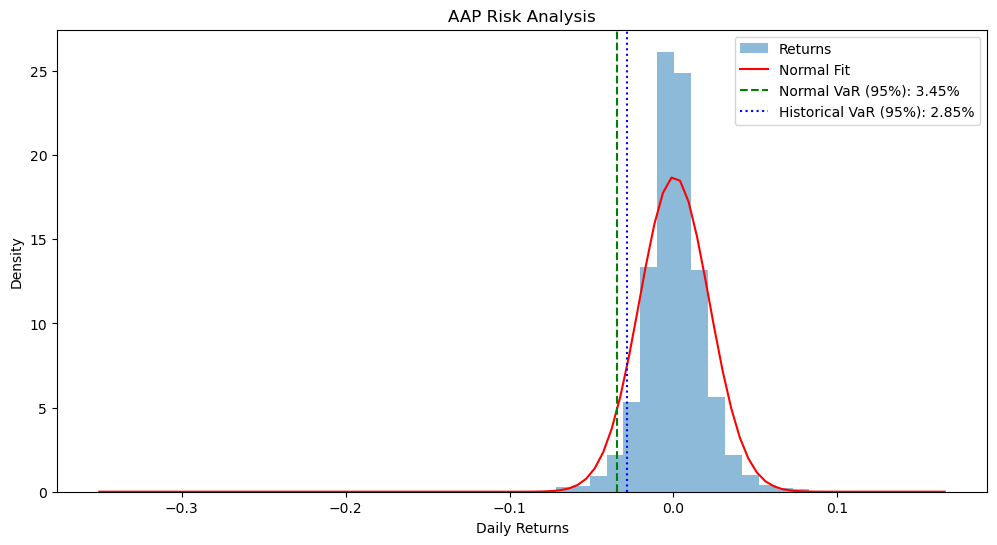


AAPL Risk Metrics:
Normal_VaR_95       : 3.45%
Historical_VaR_95   : 2.85%
T-Dist_VaR_95       : 2.90%
CVaR_95             : 4.70%
Annualized_Volatility: 33.81%

Key Interpretation:
- VaR: Maximum expected loss with 95% confidence
- CVaR: Average loss beyond VaR threshold
- Compare methods to check normality assumption


In [4]:
def full_risk_analysis(ticker, data):
    """Comprehensive risk metrics for a stock"""
    returns = data[ticker]['Adj Close'].pct_change().dropna()
    
    # Calculate VaR with different methods
    var_normal = calculate_var(returns, method='parametric')
    var_historical = calculate_var(returns, method='historical')
    var_tdist = calculate_var(returns, method='t-dist')
    
    # Expected Shortfall (CVaR)
    threshold = np.percentile(returns, 100 * (1 - 0.95))
    cvar = -returns[returns <= threshold].mean()
    
    # Plot return distribution
    plt.figure(figsize=(12, 6))
    plt.hist(returns, bins=50, density=True, alpha=0.5, label='Returns')
    
    # Plot fitted normal curve
    x = np.linspace(returns.min(), returns.max(), 100)
    plt.plot(x, norm.pdf(x, returns.mean(), returns.std()), 
             'r-', label='Normal Fit')
    
    plt.axvline(-var_normal, color='green', linestyle='--', 
                label=f'Normal VaR (95%): {var_normal:.2%}')
    plt.axvline(-var_historical, color='blue', linestyle=':',
                label=f'Historical VaR (95%): {var_historical:.2%}')
    plt.title(f'{ticker} Risk Analysis')
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    return {
        'Normal_VaR_95': var_normal,
        'Historical_VaR_95': var_historical,
        'T-Dist_VaR_95': var_tdist,
        'CVaR_95': cvar,
        'Annualized_Volatility': returns.std() * np.sqrt(252)
    }

# Example usage
aapl_risk = full_risk_analysis('AAP', cleaned_data)
print("\nAAPL Risk Metrics:")
for metric, value in aapl_risk.items():
    print(f"{metric:20}: {value:.2%}")

print("\nKey Interpretation:")
print("- VaR: Maximum expected loss with 95% confidence")
print("- CVaR: Average loss beyond VaR threshold")
print("- Compare methods to check normality assumption")

### Summary

- Normal VaR (3.45%) suggests the risk of a loss greater than 3.45% is low (5% chance).
- Historical VaR (2.85%) suggests actual past data indicates a lower expected loss than the normal distribution assumption.
- T-Dist VaR (2.90%) reflects a slightly more extreme but still moderate loss compared to the normal distribution.
- CVaR (4.70%) indicates that if the stock suffers a loss worse than 3.45%, the average loss is 4.70%—which is larger than the VaR, highlighting that extreme losses are not just possible but significantly impactful.
- Annualized Volatility (33.81%) shows that Apple’s stock is relatively volatile, indicating higher uncertainty about future prices.

## Conclusion

In this project, I conducted a Portfolio Risk Analysis for Apple Inc. (AAPL) by applying Value at Risk (VaR) and Expected Shortfall (CVaR) to assess potential downside risks in its stock price. These methods enabled us to understand the range of potential losses and the likelihood of those losses occurring within a specific confidence level.

Through the analysis, we applied three different VaR methods:

1. Normal VaR: This method assumed that the returns follow a normal distribution and estimated a potential loss of 3.45% with a 95% confidence level.

2. Historical VaR: Based on the actual historical returns, it estimated a potential loss of 2.85%, suggesting that real-world data may indicate lower extreme losses than those predicted by the normal distribution.

3. T-Distribution VaR: This method accounted for heavier tails in the return distribution, estimating a potential loss of 2.90%, which is in line with the historical method but slightly higher than the normal VaR.

Additionally, we calculated the Expected Shortfall (CVaR), which provided insights into the average loss once the VaR threshold is exceeded. The CVaR was estimated at 4.70%, highlighting the severity of potential losses during extreme market conditions beyond the 95% confidence level.

Finally, the Annualized Volatility of 33.81% indicated that Apple's stock is relatively volatile, with substantial fluctuations over the course of the year. This insight is critical for risk management and investment decisions, as it highlights the importance of considering volatility when assessing overall risk exposure.